# 캐시미션에서 내려받은 파일별 raw json을 행 구분으로 병합


In [ ]:
import os
import json

# 경로에 있는 raw json파일들 하나로 병합
def merge_json_files(directory_path, output_file_path):
    json_list = []

    # 파일 순회
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                # 각 파일을 로드 후 리스트 추가
                json_data = json.load(f)
                json_list.append(json_data)

    # 행 구분으로 저장
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for item in json_list:
            outfile.write(json.dumps(item, ensure_ascii=False) + '\n')

    print(f"raw json {output_file_path}병합 완")

# 인풋 경로
directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_json_test'
output_file_path = '/content/poc_annotation.json'  # 아웃풋 경로

# 실행
merge_json_files(directory_path, output_file_path)

raw json /content/poc_annotation.json병합 완


# 행구분된 json 파일 납품 구조로 변경
## 상세 조건은 주석확인

In [ ]:
# 캐시미션 추출되는 json 예시
#   {
#         "classClientId": "background",
#         "type": "BOX",
#         "coordinates": {
#           "x1": 0,
#           "y1": 0,
#           "x2": 1,
#           "y2": 1,
#           "type": "BOX"
#         },
#         "submissionItems": [
#           {
#             "classItemClientId": "c4d32d3c",
#             "type": "RADIO",
#             "answer": null,
#             "selectionClientIds": ["1001"]
#           },
#           {
#             "classItemClientId": "f2569f44",
#             "type": "RADIO",
#             "answer": null,
#             "selectionClientIds": ["1000"]
#           },
#           {
#             "classItemClientId": "53697e64",
#             "type": "TEXT_STRING",
#             "answer": "088,159,117,1",
#             "selectionClientIds": []
#           }
#         ],
#         "clientId": "e69f7e2d-92b6-4360-bcfb-334020c0932f",
#         "status": "DONE",
#         "failedReasons": []
#       },

## 파일, json 매칭 -> 이거는 인풋 단계에서 작업한 raw image만 잘 넣으면 필요가 없음(수정필요)

In [ ]:
import os
import json

# JSON 파일에서 파일 이름을 추출하는 함수
def extract_filenames_from_json(json_file_path):
    filenames = []
    with open(json_file_path, 'r', encoding='utf-8') as file:
        for line in file:  # 한 줄씩 JSON 객체를 읽어옴
            try:
                data = json.loads(line.strip())
                filenames.append(data['source']['fileName'])  # 파일 이름 추출
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    return filenames

# 디렉토리에서 이미지 파일 목록을 가져오는 함수
def get_image_filenames_from_directory(directory_path):
    image_filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_filenames.append(filename)
    return image_filenames

# JSON 파일과 이미지 디렉토리 경로
json_file_path = '/content/poc_annotation.json'  # JSON 파일 경로
image_directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image'  # 이미지 파일이 저장된 디렉토리 경로

# JSON 파일에서 파일 이름을 추출
json_filenames = extract_filenames_from_json(json_file_path)

# 디렉토리에서 이미지 파일 이름을 가져옴
image_filenames = get_image_filenames_from_directory(image_directory_path)


json_filenames_with_extension = [f"{os.path.splitext(filename)[0]}.jpg" for filename in json_filenames]  # 예: jpg 확장자 사용

missing_in_directory = [filename for filename in json_filenames_with_extension if filename not in image_filenames]


missing_in_json = [filename for filename in image_filenames if filename not in json_filenames_with_extension]


print("JSON존재  raw에 없는 파일들:")
print(missing_in_directory)

print("\n raw에 있지만 JSON에 없음:")
print(missing_in_json)

JSON존재  raw에 없는 파일들:
['filtered (94).jpg']

 raw에 있지만 JSON에 없음:
['filtered (94).png']


# 캐시미션 json -> 납품구조로 변경

In [ ]:
# 10.18 수정

import os
from PIL import Image
import json

# 경로상 이미지 파일 width와 height 초기화
def get_image_dimensions(directory_path):
    image_dimensions = {}

    # 이미지 파일 순회
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg',"JPG","PNG","JPEG")):
            file_path = os.path.join(directory_path, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                image_dimensions[filename] = {"width": width, "height": height}

    return image_dimensions

# 인풋 경로
directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image_test'

# 원본 raw data width, height 반영
image_info = get_image_dimensions(directory_path)


# 카테고리별 순서를 지정 -> 캐시미션 업데이트 후 group_underaly값 변경해야됨. -> 반영 10.17에 반영 예정
category_order = [
    "background", "group_underlay", "image", "sticker",
    "text_underlay", "decoration", "text", "item", "logo"
]

# JSON 데이터를 변환하는 함수
def convert_json(data, index, image_info):
    # 파일 이름에 해당하는 width, height 딕셔너리 형태 키 값으로 반영
    file_name = data['source']['fileName']
    if file_name in image_info:
        image_width = image_info[file_name]['width']
        image_height = image_info[file_name]['height']
        canvas_size = [image_width, image_height]
    else:
        # 이미지 크기가 없는 경우 기본값으로 세팅해놓음
        canvas_size = [1, 1]

    # 파일 정보 변환
    new_data = {
        "id": index,  # id는 각 파일별로 고유하게 설정
        "file_name": data['source']['fileName'],
        "canvas_size": canvas_size,
        "type": "MMS",
        "elements": []
    }

    # units를 category_order에 따라 정렬
    # sorted_units = sorted(data['units'], key=lambda x: category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order))
    # sorted_units = sorted(data['units'], key=lambda x: (
    # category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
    # x['coordinates']['y1'],  # 상단 기준 정렬
    # x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
    # ))
    sorted_units = sorted(
        [unit for unit in data['units'] if unit.get('status') != 'WRONG'],  # status가 "wrong"인 애들은 제외
        key=lambda x: (
            category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
            x['coordinates']['y1'],  # 상단 기준 정렬
            x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
        )
    )

    # element_id를 추적할 변수
    element_id = 0

    # 각 정렬된 unit항목 내 정보들 처리
    for unit in sorted_units:
        element = {
            "element_id": element_id,
            "category": unit['classClientId'],
            "group": None,  # 기본값 설정
            "bbox": [],  # 나중에 채워짐
            "raw_text": "",
            "text_newline": [],
            "text_alignment": "",
            "highlight_text": "",
            "font_color": [],
            "font_type": None,
            "font_size": None,
            "highlight_color": [],
            "is_gradient": None,
            "gradient_color": None,
            "is_background": 0,
            "background_color": []
        }

        # 좌표 처리 (bbox와 raw_bbox)
        x1, y1, x2, y2 = unit['coordinates']['x1'], unit['coordinates']['y1'], unit['coordinates']['x2'], unit['coordinates']['y2']

        # 이미지 크기 bbox 좌표 조건 반영
        center_x = round((x1 + x2) / 2 * canvas_size[0], 1)
        center_y = round((y1 + y2) / 2 * canvas_size[1], 1)
        box_width = int((x2 - x1) * canvas_size[0])
        box_height = int((y2 - y1) * canvas_size[1])

        # bbox 값 설정
        bbox = [center_x, center_y, element_id, box_width, box_height]
        element['bbox'] = bbox



        # background 조건 적용'

        # background_group
        if unit['classClientId'] == "background" and len(unit['submissionItems']) > 3:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element['group'] = None  # 기타 값 처리
          else:
            element['group'] = None  # selectionClientIds가 비어있을 경우 None 설정



        # background_is_gradient
          selectionClientId_3 = unit['submissionItems'][1]['selectionClientIds'][0]
          element['is_gradient'] = 1 if selectionClientId_3 == "1001" else 0



        # background_is_background
          selectionClientId_2 = unit['submissionItems'][2]['selectionClientIds'][0]
          element['is_background'] = 1 if selectionClientId_2 == "1000" else 2




        # background_background_color
          if element['is_background'] == 1:
            background_color = unit['submissionItems'][3]['answer']
            if "RGB" in background_color:
              rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
              rgb_values = [int(c) for c in rgb_values_str.split(",")]
              element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
            else:
              element['background_color'] = ["color error"]
          else:
            element['background_color'] = [file_name]








        # group_underlay 조건 적용

        # group_underlay_group
        elif unit['classClientId'] == "group_underlay" and len(unit['submissionItems']) > 1:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element['group'] = None  # 기타 값 처리
          else:
            element['group'] = None  # selectionClientIds가 비어있을 경우 None 설정


        # group_underlay_background_color
          background_color = unit['submissionItems'][1]['answer']
          if "RGB" in background_color:
            rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
            rgb_values = [int(c) for c in rgb_values_str.split(",")]
            element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
          else:
            element['background_color'] = ["color error"]


        # group_underlay_is_gradient
          selectionClientId_2 = unit['submissionItems'][2]['selectionClientIds'][0]
          element['is_gradient'] = 1 if selectionClientId_2 == "1001" else 0



        # image 조건 적용

        # image_group
        elif unit['classClientId'] == "image" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None




        # sticker 조건 적용

        # sticker_group
        elif unit['classClientId'] == "sticker" and len(unit['submissionItems']) > 2:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None

        # sticker_background_color
          background_color = unit['submissionItems'][1]['answer']
          if "RGB" in background_color:
            rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
            rgb_values = [int(c) for c in rgb_values_str.split(",")]
            element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
          else:
            element['background_color'] = ["color error"]

        # sticker_is_gradient
          selectionClientId_2 = unit['submissionItems'][2]['selectionClientIds'][0]
          element['is_gradient'] = 1 if selectionClientId_2 == "1001" else 0


        # text_underlay 조건 적용

        # text_underlay_group
        elif unit['classClientId'] == "text_underlay" and len(unit['submissionItems']) > 1:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None


        # text_underlay_background_color
          background_color = unit['submissionItems'][1]['answer']
          if "RGB" in background_color:
            rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
            rgb_values = [int(c) for c in rgb_values_str.split(",")]
            element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
          else:
            element['background_color'] = ["color"]


        # text_underlay_is_gradient
          selectionClientId_2 = unit['submissionItems'][2]['selectionClientIds'][0]
          element['is_gradient'] = 1 if selectionClientId_2 == "1001" else 0






        # decoration 조건 적용

        # decoration group
        elif unit['classClientId'] == "decoration" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None




        # text 조건 적용

        # text group
        elif unit['classClientId'] == "text" and len(unit['submissionItems']) > 6:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None

        # raw_text
          element['raw_text'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] is not None else ""

        # text_newline
          element['text_newline'] = unit['submissionItems'][2]['answer'].split("\n") if unit['submissionItems'][2]['answer'] else []

        # text_alignment
          if len(unit['submissionItems']) > 3 and unit['submissionItems'][3]['selectionClientIds']:
            selectionClientId_4 = unit['submissionItems'][3]['selectionClientIds'][0]
            if selectionClientId_4 == "1000":
              element['text_alignment'] = "middle"
            elif selectionClientId_4 == "1001":
              element['text_alignment'] = "left"
            elif selectionClientId_4 == "1002":
              element['text_alignment'] = "right"
          else:
            element['text_alignment'] = ""

        # highlight_text
          element['highlight_text'] = unit['submissionItems'][4]['answer'] if unit['submissionItems'][4]['answer'] else ""




        # font_color
          if len(unit['submissionItems']) > 5 and unit['submissionItems'][5]['answer']:
            font_color = unit['submissionItems'][5]['answer']

            if "RGB" in font_color:
              rgb_values_str = font_color.replace("RGB(", "").replace(")", "")
              font_color = [int(c) for c in rgb_values_str.split(",")]
              element['font_color'] = font_color + [1]
            else:
              element['font_color'] = []
          else:
            element['font_color'] = []


        # highlight_color
          if len(unit['submissionItems']) > 6 and unit['submissionItems'][6]['answer']:
            highlight_color = unit['submissionItems'][6]['answer']

            if "RGB" in highlight_color:
              rgb_values_str = highlight_color.replace("RGB(", "").replace(")", "")
              highlight_color = [int(c) for c in rgb_values_str.split(",")]
              element['highlight_color'] = highlight_color+ [1]
            else:
              element['highlight_color'] = []

          else:
            element['highlight_color'] = []



        # text_is_gradient
          selectionClientId_2 = unit['submissionItems'][7]['selectionClientIds'][0]
          element['is_gradient'] = 1 if selectionClientId_2 == "1001" else 0







          # item 조건 적용
        elif unit['classClientId'] == "item" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None




          # logo 조건 적용
        elif unit['classClientId'] == "logo" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None


        # element 추가
        new_data['elements'].append(element)

        # element_id 증가
        element_id += 1

    return new_data

file_path = '/content/poc_annotation.json'

# 줄 단위로 JSON 객체 로드
output_json_list = []
with open(file_path, 'r') as f:
    for index, line in enumerate(f):
        # 각 줄을 JSON 객체로 변환
        input_json = json.loads(line.strip())
        # 변환 실행
        output_json = convert_json(input_json, index, image_info)
        output_json_list.append(output_json)

# 변환된 JSON 리스트
print(json.dumps(output_json_list, indent=4))

# 변환된 JSON 저장
output_file_path = '/content/output.json'

with open(output_file_path, 'w', encoding='utf-8') as outfile:
    json.dump(output_json_list, outfile, ensure_ascii=False, indent=4)

print(f"변환된 JSON 파일 {output_file_path}에 저장")

[
    {
        "id": 0,
        "file_name": "IMG_1862.JPG",
        "canvas_size": [
            720,
            780
        ],
        "type": "MMS",
        "elements": [
            {
                "element_id": 0,
                "category": "background",
                "group": null,
                "bbox": [
                    360.0,
                    390.0,
                    0,
                    720,
                    780
                ],
                "raw_text": "",
                "text_newline": [],
                "text_alignment": "",
                "highlight_text": "",
                "font_color": [],
                "font_type": null,
                "font_size": null,
                "highlight_color": [],
                "is_gradient": 0,
                "gradient_color": null,
                "is_background": 2,
                "background_color": [
                    "IMG_1862.JPG"
                ]
            },
            {
                

# 10.18ver 보존

In [ ]:
# main 원본

import os
from PIL import Image
import json

# 경로상 이미지 파일 width와 height 초기화
def get_image_dimensions(directory_path):
    image_dimensions = {}

    # 이미지 파일 순회
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(directory_path, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                image_dimensions[filename] = {"width": width, "height": height}

    return image_dimensions

# 인풋 경로
directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image_test'

# 원본 raw data width, height 반영
image_info = get_image_dimensions(directory_path)


# 카테고리별 순서를 지정 -> 캐시미션 업데이트 후 group_underaly값 변경해야됨. -> 반영 10.17에 반영 예정
category_order = [
    "background", "group_underlay", "image", "sticker",
    "text_underlay", "decoration", "text", "item", "logo"
]

# JSON 데이터를 변환하는 함수
def convert_json(data, index, image_info):
    # 파일 이름에 해당하는 width, height 딕셔너리 형태 키 값으로 반영
    file_name = data['source']['fileName']
    if file_name in image_info:
        image_width = image_info[file_name]['width']
        image_height = image_info[file_name]['height']
        canvas_size = [image_width, image_height]
    else:
        # 이미지 크기가 없는 경우 기본값으로 세팅해놓음
        canvas_size = [1, 1]

    # 파일 정보 변환
    new_data = {
        "id": index,  # id는 각 파일별로 고유하게 설정
        "file_name": data['source']['fileName'],
        "canvas_size": canvas_size,
        "type": "MMS",
        "elements": []
    }

    # units를 category_order에 따라 정렬
    # sorted_units = sorted(data['units'], key=lambda x: category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order))
    # sorted_units = sorted(data['units'], key=lambda x: (
    # category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
    # x['coordinates']['y1'],  # 상단 기준 정렬
    # x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
    # ))
    sorted_units = sorted(
        [unit for unit in data['units'] if unit.get('status') != 'WRONG'],  # status가 "wrong"인 애들은 제외
        key=lambda x: (
            category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
            x['coordinates']['y1'],  # 상단 기준 정렬
            x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
        )
    )

    # element_id를 추적할 변수
    element_id = 0

    # 각 정렬된 unit항목 내 정보들 처리
    for unit in sorted_units:
        element = {
            "element_id": element_id,
            "category": unit['classClientId'],
            "group": None,  # 기본값 설정
            "bbox": [],  # 나중에 채워짐
            "raw_text": "",
            "text_newline": [],
            "text_alignment": "",
            "highlight_text": "",
            "font_color": [],
            "font_type": None,
            "font_size": None,
            "highlight_color": [],
            "is_gradient": None,
            "gradient_color": None,
            "is_background": 0,
            "background_color": []
        }

        # 좌표 처리 (bbox와 raw_bbox)
        x1, y1, x2, y2 = unit['coordinates']['x1'], unit['coordinates']['y1'], unit['coordinates']['x2'], unit['coordinates']['y2']

        # 이미지 크기 bbox 좌표 조건 반영
        center_x = round((x1 + x2) / 2 * canvas_size[0], 1)
        center_y = round((y1 + y2) / 2 * canvas_size[1], 1)
        box_width = int((x2 - x1) * canvas_size[0])
        box_height = int((y2 - y1) * canvas_size[1])

        # bbox 값 설정
        bbox = [center_x, center_y, element_id, box_width, box_height]
        element['bbox'] = bbox

        # background 조건 적용'

        if unit['classClientId'] == "background" and len(unit['submissionItems']) > 2:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element['group'] = None  # 기타 값 처리
          else:
            element['group'] = None  # selectionClientIds가 비어있을 경우 None 설정

          selectionClientId_2 = unit['submissionItems'][1]['selectionClientIds'][0]
          element['is_background'] = 1 if selectionClientId_2 == "1000" else 2

          if element['is_background'] == 1:
            background_color = unit['submissionItems'][2]['answer']
            if "RGB" in background_color:
              rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
              rgb_values = [int(c) for c in rgb_values_str.split(",")]
              element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
            else:
              element['background_color'] = ["color error"]
          else:
            element['background_color'] = [file_name]









        # group_underlay 조건 적용
        elif unit['classClientId'] == "group_underlay" and len(unit['submissionItems']) > 1:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element['group'] = None  # 기타 값 처리
          else:
            element['group'] = None  # selectionClientIds가 비어있을 경우 None 설정

          background_color = unit['submissionItems'][1]['answer']
          if "RGB" in background_color:
            rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
            rgb_values = [int(c) for c in rgb_values_str.split(",")]
            element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
          else:
            element['background_color'] = ["color error"]





        # image 조건 적용
        elif unit['classClientId'] == "image" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None




        # sticker 조건 적용
        elif unit['classClientId'] == "sticker" and len(unit['submissionItems']) > 1:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None

          background_color = unit['submissionItems'][1]['answer']
          if "RGB" in background_color:
            rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
            rgb_values = [int(c) for c in rgb_values_str.split(",")]
            element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
          else:
            element['background_color'] = ["color error"]




        # text_underlay 조건 적용
        elif unit['classClientId'] == "text_underlay" and len(unit['submissionItems']) > 1:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None

          background_color = unit['submissionItems'][1]['answer']
          if "RGB" in background_color:
            rgb_values_str = background_color.replace("RGB(", "").replace(")", "")
            rgb_values = [int(c) for c in rgb_values_str.split(",")]
            element['background_color'] = rgb_values + [1]  # 마지막에 ,1 추가
          else:
            element['background_color'] = ["color"]




        # decoration 조건 적용
        elif unit['classClientId'] == "decoration" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None




        # text 조건 적용
        elif unit['classClientId'] == "text" and len(unit['submissionItems']) > 6:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None

          element['raw_text'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] is not None else ""
          element['text_newline'] = unit['submissionItems'][2]['answer'].split("\n") if unit['submissionItems'][2]['answer'] else []


          if len(unit['submissionItems']) > 3 and unit['submissionItems'][3]['selectionClientIds']:
            selectionClientId_4 = unit['submissionItems'][3]['selectionClientIds'][0]
            if selectionClientId_4 == "1000":
              element['text_alignment'] = "middle"
            elif selectionClientId_4 == "1001":
              element['text_alignment'] = "left"
            elif selectionClientId_4 == "1002":
              element['text_alignment'] = "right"
          else:
            element['text_alignment'] = ""

          element['highlight_text'] = unit['submissionItems'][4]['answer'] if unit['submissionItems'][4]['answer'] else ""





          if len(unit['submissionItems']) > 5 and unit['submissionItems'][5]['answer']:
            font_color = unit['submissionItems'][5]['answer']

            if "RGB" in font_color:
              rgb_values_str = font_color.replace("RGB(", "").replace(")", "")
              font_color = [int(c) for c in rgb_values_str.split(",")]
              element['font_color'] = font_color
            else:
              element['font_color'] = ["color_error"]
          else:
            element['font_color'] = []

          if len(unit['submissionItems']) > 6 and unit['submissionItems'][6]['answer']:
            highlight_color = unit['submissionItems'][6]['answer']

            if "RGB" in highlight_color:
              rgb_values_str = highlight_color.replace("RGB(", "").replace(")", "")
              highlight_color = [int(c) for c in rgb_values_str.split(",")]
              element['highlight_color'] = highlight_color
            else:
              element['highlight_color'] = ["color_error"]

          else:
            element['highlight_color'] = ["color_error"]






          # item 조건 적용
        elif unit['classClientId'] == "item" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None




          # logo 조건 적용
        elif unit['classClientId'] == "logo" and len(unit['submissionItems']) > 0:
          if unit['submissionItems'][0]['selectionClientIds']:
            selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

            if selectionClientId_1 == "1000":
              element['group'] = None
            elif selectionClientId_1 == "1001":
              element['group'] = "0"
            elif selectionClientId_1 == "1002":
              element['group'] = "1"
            elif selectionClientId_1 == "1003":
              element['group'] = "2"
            else:
              element["group"] = None
          else:
            selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정
            element['group'] = None


        # element 추가
        new_data['elements'].append(element)

        # element_id 증가
        element_id += 1

    return new_data

file_path = '/content/poc_annotation.json'

# 줄 단위로 JSON 객체 로드
output_json_list = []
with open(file_path, 'r') as f:
    for index, line in enumerate(f):
        # 각 줄을 JSON 객체로 변환
        input_json = json.loads(line.strip())
        # 변환 실행
        output_json = convert_json(input_json, index, image_info)
        output_json_list.append(output_json)

# 변환된 JSON 리스트
print(json.dumps(output_json_list, indent=4))

# 변환된 JSON 저장
output_file_path = '/content/output.json'

with open(output_file_path, 'w', encoding='utf-8') as outfile:
    json.dump(output_json_list, outfile, ensure_ascii=False, indent=4)

print(f"변환된 JSON 파일 {output_file_path}에 저장")

TypeError: argument of type 'NoneType' is not iterable

# (안씀) 10.17 이전

In [ ]:
#  # main 원본

# import os
# from PIL import Image
# import json

# # 경로상 이미지 파일 width와 height 초기화
# def get_image_dimensions(directory_path):
#     image_dimensions = {}

#     # 이미지 파일 순회
#     for filename in os.listdir(directory_path):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(directory_path, filename)
#             with Image.open(file_path) as img:
#                 width, height = img.size
#                 image_dimensions[filename] = {"width": width, "height": height}

#     return image_dimensions

# # 인풋 경로
# directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image'

# # 원본 raw data width, height 반영
# image_info = get_image_dimensions(directory_path)


# # 카테고리별 순서를 지정 -> 캐시미션 업데이트 후 group_underaly값 변경해야됨. -> 반영 10.16 group_underlay
# category_order = [
#     "background", "group_underlay", "image", "sticker",
#     "text_underlay", "decoration", "text", "item", "logo"
# ]

# # JSON 데이터를 변환하는 함수
# def convert_json(data, index, image_info):
#     # 파일 이름에 해당하는 width, height 딕셔너리 형태 키 값으로 반영
#     file_name = data['source']['fileName']
#     if file_name in image_info:
#         image_width = image_info[file_name]['width']
#         image_height = image_info[file_name]['height']
#         canvas_size = [image_width, image_height]
#     else:
#         # 이미지 크기가 없는 경우 기본값으로 세팅해놓음
#         canvas_size = [1, 1]

#     # 파일 정보 변환
#     new_data = {
#         "id": index,  # id는 각 파일별로 고유하게 설정
#         "file_name": data['source']['fileName'],
#         "canvas_size": canvas_size,
#         "type": "MMS",
#         "elements": []
#     }

#     # units를 category_order에 따라 정렬
#     # sorted_units = sorted(data['units'], key=lambda x: category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order))
#     # sorted_units = sorted(data['units'], key=lambda x: (
#     # category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
#     # x['coordinates']['y1'],  # 상단 기준 정렬
#     # x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
#     # ))
#     sorted_units = sorted(
#         [unit for unit in data['units'] if unit.get('status') != 'WRONG'],  # status가 "wrong"인 애들은 제외
#         key=lambda x: (
#             category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
#             x['coordinates']['y1'],  # 상단 기준 정렬
#             x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
#         )
#     )

#     # element_id를 추적할 변수
#     element_id = 0

#     # 각 정렬된 unit항목 내 정보들 처리
#     for unit in sorted_units:
#         element = {
#             "element_id": element_id,
#             "category": unit['classClientId'],
#             "group": None,  # 기본값 설정
#             "bbox": [],  # 나중에 채워짐
#             "raw_text": "",
#             "text_newline": [],
#             "text_alignment": "",
#             "highlight_text": "",
#             "font_color": [],
#             "font_type": None,
#             "font_size": None,
#             "highlight_color": [],
#             "is_gradient": None,
#             "gradient_color": None,
#             "is_background": 0,
#             "background_color": []
#         }

#         # 좌표 처리 (bbox와 raw_bbox)
#         x1, y1, x2, y2 = unit['coordinates']['x1'], unit['coordinates']['y1'], unit['coordinates']['x2'], unit['coordinates']['y2']

#         # 이미지 크기 bbox 좌표 조건 반영
#         center_x = round((x1 + x2) / 2 * canvas_size[0], 1)
#         center_y = round((y1 + y2) / 2 * canvas_size[1], 1)
#         box_width = int((x2 - x1) * canvas_size[0])
#         box_height = int((y2 - y1) * canvas_size[1])

#         # bbox 값 설정
#         bbox = [center_x, center_y, element_id, box_width, box_height]
#         element['bbox'] = bbox

#         # background 조건 적용
#         if unit['classClientId'] == "background" and len(unit['submissionItems']) > 2:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             selectionClientId_2 = unit['submissionItems'][1]['selectionClientIds'][0]

#             element['group'] = None
#             element['is_background'] = 1 if selectionClientId_2 == "1000" else 2

#             background_color = unit['submissionItems'][2]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # group_underlay 조건 적용
#         elif unit['classClientId'] == "group_underaly" and len(unit['submissionItems']) > 1:
#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]
#         # image 조건 적용
#         elif unit['classClientId'] == "image" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#         # sticker 조건 적용
#         elif unit['classClientId'] == "sticker" and len(unit['submissionItems']) > 1:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # text_underlay 조건 적용
#         elif unit['classClientId'] == "text_underlay" and len(unit['submissionItems']) > 1:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # decoration 조건 적용
#         elif unit['classClientId'] == "decoration" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None if selectionClientId_1 == "1000" else None

#         # text 조건 적용
#         elif unit['classClientId'] == "text" and len(unit['submissionItems']) > 6:
#             if unit['submissionItems'][0]['selectionClientIds']:
#               selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             else:
#               selectionClientId_1 = None  # 리스트가 비어있으면 None으로 설정

#             element['group'] = None

#             element['raw_text'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] is not None else ""
#             element['text_newline'] = unit['submissionItems'][2]['answer'].split("\n") if unit['submissionItems'][2]['answer'] else []

#             if len(unit['submissionItems']) > 3 and unit['submissionItems'][3]['selectionClientIds']:
#               selectionClientId_4 = unit['submissionItems'][3]['selectionClientIds'][0]
#               if selectionClientId_4 == "1000":
#                 element['text_alignment'] = "middle"
#               elif selectionClientId_4 == "1001":
#                 element['text_alignment'] = "left"
#               elif selectionClientId_4 == "1002":
#                 element['text_alignment'] = "right"
#             else:
#               element['text_alignment'] = ""

#             element['highlight_text'] = unit['submissionItems'][4]['answer'] if unit['submissionItems'][4]['answer'] else ""

#             if len(unit['submissionItems']) > 5 and unit['submissionItems'][5]['answer']:
#               font_color = unit['submissionItems'][5]['answer'].split(",")
#             else:
#               font_color = []  # answer 값이 None일 경우 빈 리스트로 처리
#             element['font_color'] = [int(c) if c.isdigit() else c for c in font_color if c]

#             if len(unit['submissionItems']) > 6 and unit['submissionItems'][6]['answer']:
#               highlight_color = unit['submissionItems'][6]['answer'].split(",")
#             else:
#               highlight_color = []
#             element['highlight_color'] = [int(c) if c.isdigit() else c for c in highlight_color if c]

#           # item 조건 적용
#         elif unit['classClientId'] == "item" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#           # logo 조건 적용
#         elif unit['classClientId'] == "logo" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None


#         # element 추가
#         new_data['elements'].append(element)

#         # element_id 증가
#         element_id += 1

#     return new_data

# file_path = '/content/poc_annotation.json'

# # 줄 단위로 JSON 객체 로드
# output_json_list = []
# with open(file_path, 'r') as f:
#     for index, line in enumerate(f):
#         # 각 줄을 JSON 객체로 변환
#         input_json = json.loads(line.strip())
#         # 변환 실행
#         output_json = convert_json(input_json, index, image_info)
#         output_json_list.append(output_json)

# # 변환된 JSON 리스트
# print(json.dumps(output_json_list, indent=4))

# # 변환된 JSON 저장
# output_file_path = '/content/output.json'

# with open(output_file_path, 'w', encoding='utf-8') as outfile:
#     json.dump(output_json_list, outfile, ensure_ascii=False, indent=4)

# print(f"변환된 JSON 파일 {output_file_path}에 저장")

# 안씀(빈 값 예외처리 없음)

In [ ]:
# # 라디오 버튼 파싱기능 추가

# import os
# from PIL import Image
# import json

# # 경로상 이미지 파일 width와 height 초기화
# def get_image_dimensions(directory_path):
#     image_dimensions = {}

#     # 이미지 파일 순회
#     for filename in os.listdir(directory_path):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(directory_path, filename)
#             with Image.open(file_path) as img:
#                 width, height = img.size
#                 image_dimensions[filename] = {"width": width, "height": height}

#     return image_dimensions

# # 인풋 경로
# directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image'

# # 원본 raw data width, height 반영
# image_info = get_image_dimensions(directory_path)


# # 카테고리별 순서를 지정 -> 캐시미션 업데이트 후 group_underaly값 변경해야됨.
# category_order = [
#     "background", "group_underaly", "image", "sticker",
#     "text_underlay", "decoration", "text", "item", "logo"
# ]

# # JSON 데이터를 변환하는 함수
# def convert_json(data, index, image_info):
#     # 파일 이름에 해당하는 width, height 딕셔너리 형태 키 값으로 반영
#     file_name = data['source']['fileName']
#     if file_name in image_info:
#         image_width = image_info[file_name]['width']
#         image_height = image_info[file_name]['height']
#         canvas_size = [image_width, image_height]
#     else:
#         # 이미지 크기가 없는 경우 기본값으로 세팅해놓음
#         canvas_size = [1, 1]

#     # 파일 정보 변환
#     new_data = {
#         "id": index,  # id는 각 파일별로 고유하게 설정
#         "file_name": data['source']['fileName'],
#         "canvas_size": canvas_size,
#         "type": "MMS",
#         "elements": []
#     }

#     # units를 category_order에 따라 정렬
#     # sorted_units = sorted(data['units'], key=lambda x: category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order))
#     # sorted_units = sorted(data['units'], key=lambda x: (
#     # category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
#     # x['coordinates']['y1'],  # 상단 기준 정렬
#     # x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
#     # ))
#     sorted_units = sorted(
#         [unit for unit in data['units'] if unit.get('status') != 'WRONG'],  # status가 "wrong"인 애들은 제외
#         key=lambda x: (
#             category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
#             x['coordinates']['y1'],  # 상단 기준 정렬
#             x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
#         )
#     )

#     # element_id를 추적할 변수
#     element_id = 0

#     # 각 정렬된 unit항목 내 정보들 처리
#     for unit in sorted_units:
#         element = {
#             "element_id": element_id,
#             "category": unit['classClientId'],
#             "group": None,  # 기본값 설정
#             "bbox": [],  # 나중에 채워짐
#             "raw_text": "",
#             "text_newline": [],
#             "text_alignment": "",
#             "highlight_text": "",
#             "font_color": [],
#             "font_type": None,
#             "font_size": None,
#             "highlight_color": [],
#             "is_gradient": None,
#             "gradient_color": None,
#             "is_background": 0,
#             "background_color": []
#         }

#         # 좌표 처리 (bbox와 raw_bbox)
#         x1, y1, x2, y2 = unit['coordinates']['x1'], unit['coordinates']['y1'], unit['coordinates']['x2'], unit['coordinates']['y2']

#         # 이미지 크기 bbox 좌표 조건 반영
#         center_x = round((x1 + x2) / 2 * canvas_size[0], 1)
#         center_y = round((y1 + y2) / 2 * canvas_size[1], 1)
#         box_width = int((x2 - x1) * canvas_size[0])
#         box_height = int((y2 - y1) * canvas_size[1])

#         # bbox 값 설정
#         bbox = [center_x, center_y, element_id, box_width, box_height]
#         element['bbox'] = bbox

#         # background 조건 적용
#         if unit['classClientId'] == "background" and len(unit['submissionItems']) > 2:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             selectionClientId_2 = unit['submissionItems'][1]['selectionClientIds'][0]

#             element['group'] = None
#             element['is_background'] = 1 if selectionClientId_2 == "1000" else 2

#             background_color = unit['submissionItems'][2]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # group_underlay 조건 적용
#         elif unit['classClientId'] == "group_underaly" and len(unit['submissionItems']) > 1:
#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]
#         # image 조건 적용
#         elif unit['classClientId'] == "image" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#         # sticker 조건 적용
#         elif unit['classClientId'] == "sticker" and len(unit['submissionItems']) > 1:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # text_underlay 조건 적용
#         elif unit['classClientId'] == "text_underlay" and len(unit['submissionItems']) > 1:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # decoration 조건 적용
#         elif unit['classClientId'] == "decoration" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None if selectionClientId_1 == "1000" else None

#         # text 조건 적용
#         elif unit['classClientId'] == "text" and len(unit['submissionItems']) > 6:

#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]

#             element['group'] = None

#             element['raw_text'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] is not None else ""
#             element['text_newline'] = unit['submissionItems'][2]['answer'].split(",") if unit['submissionItems'][2]['answer'] else []

#             selectionClientId_4 = unit['submissionItems'][3]['selectionClientIds'][0]
#             if selectionClientId_4 == "1000":
#                 element['text_alignment'] = "middle"
#             elif selectionClientId_4 == "1001":
#                 element['text_alignment'] = "left"
#             elif selectionClientId_4 == "1002":
#                 element['text_alignment'] = "right"

#             element['highlight_text'] = unit['submissionItems'][4]['answer'] if unit['submissionItems'][4]['answer'] else ""

#             font_color = unit['submissionItems'][5]['answer'].split(",")
#             element['font_color'] = [int(c) if c.isdigit() else c for c in font_color if c]

#             highlight_color = unit['submissionItems'][6]['answer'].split(",") if unit['submissionItems'][6]['answer'] is not None else ""
#             highlight_color_list = highlight_color if highlight_color else []
#             element['highlight_color'] = [int(c) if c.isdigit() else c for c in highlight_color if c]

#           # item 조건 적용
#         elif unit['classClientId'] == "item" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#           # logo 조건 적용
#         elif unit['classClientId'] == "logo" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None


#         # element 추가
#         new_data['elements'].append(element)

#         # element_id 증가
#         element_id += 1

#     return new_data

# file_path = '/content/poc_annotation.json'

# # 줄 단위로 JSON 객체 로드
# output_json_list = []
# with open(file_path, 'r') as f:
#     for index, line in enumerate(f):
#         # 각 줄을 JSON 객체로 변환
#         input_json = json.loads(line.strip())
#         # 변환 실행
#         output_json = convert_json(input_json, index, image_info)
#         output_json_list.append(output_json)

# # 변환된 JSON 리스트
# print(json.dumps(output_json_list, indent=4))

# # 변환된 JSON 저장
# output_file_path = '/content/output.json'

# with open(output_file_path, 'w', encoding='utf-8') as outfile:
#     json.dump(output_json_list, outfile, ensure_ascii=False, indent=4)

# print(f"변환된 JSON 파일 {output_file_path}에 저장")

# 안씀 (\n 제외처리) -> 입력값 당시에 행 구분으로 파싱해오면 됨.

In [ ]:
import json

# JSON 파일 경로 수정 (올바른 경로로)
input_file_path = '/content/output.json'
output_file_path = '/content/output_s.json'

# JSON 파일 불러오기
with open(input_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# \n 제거하는 함수
def remove_newlines_from_text_newline(obj):
    if isinstance(obj, list):
        return [item.replace('\n', '') if isinstance(item, str) else item for item in obj]
    elif isinstance(obj, dict):
        if 'text_newline' in obj:
            obj['text_newline'] = remove_newlines_from_text_newline(obj['text_newline'])
        return {key: remove_newlines_from_text_newline(value) for key, value in obj.items()}
    return obj

# 전체 데이터에서 \n 제거
cleaned_data = remove_newlines_from_text_newline(data)

# 결과를 새로운 파일에 저장 (output_s.json)
with open(output_file_path, 'w', encoding='utf-8') as file:
    json.dump(cleaned_data, file, ensure_ascii=False, indent=4)

print("모든 text_newline의 \\n이 제거되어 output_s.json에 저장되었습니다.")

모든 text_newline의 \n이 제거되어 output_s.json에 저장되었습니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## (안씀) status 미반영

In [ ]:
# status 미반영
# # 라디오 버튼 파싱기능 추가

# import os
# from PIL import Image
# import json

# # 경로상 이미지 파일 width와 height 초기화
# def get_image_dimensions(directory_path):
#     image_dimensions = {}

#     # 이미지 파일 순회
#     for filename in os.listdir(directory_path):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(directory_path, filename)
#             with Image.open(file_path) as img:
#                 width, height = img.size
#                 image_dimensions[filename] = {"width": width, "height": height}

#     return image_dimensions

# # 인풋 경로
# directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image'

# # 원본 raw data width, height 반영
# image_info = get_image_dimensions(directory_path)


# # 카테고리별 순서를 지정
# category_order = [
#     "background", "group_underaly", "image", "sticker",
#     "text_underlay", "decoration", "text", "item", "logo"
# ]

# # JSON 데이터를 변환하는 함수
# def convert_json(data, index, image_info):
#     # 파일 이름에 해당하는 width, height 딕셔너리 형태 키 값으로 반영
#     file_name = data['source']['fileName']
#     if file_name in image_info:
#         image_width = image_info[file_name]['width']
#         image_height = image_info[file_name]['height']
#         canvas_size = [image_width, image_height]
#     else:
#         # 이미지 크기가 없는 경우 기본값으로 세팅해놓음
#         canvas_size = [1, 1]

#     # 파일 정보 변환
#     new_data = {
#         "id": index,  # id는 각 파일별로 고유하게 설정
#         "file_name": data['source']['fileName'],
#         "canvas_size": canvas_size,
#         "type": "MMS",
#         "elements": []
#     }

#     # units를 category_order에 따라 정렬
#     # sorted_units = sorted(data['units'], key=lambda x: category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order))
#     sorted_units = sorted(data['units'], key=lambda x: (
#     category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order),
#     x['coordinates']['y1'],  # 상단 기준 정렬
#     x['coordinates']['x1']   # 동일 상단일 경우 왼쪽 기준 정렬
#     ))
#     # element_id를 추적할 변수
#     element_id = 0

#     # 각 정렬된 unit항목 내 정보들 처리
#     for unit in sorted_units:
#         element = {
#             "element_id": element_id,
#             "category": unit['classClientId'],
#             "group": None,  # 기본값 설정
#             "bbox": [],  # 나중에 채워짐
#             "raw_text": "",
#             "text_newline": [],
#             "text_alignment": "",
#             "highlight_text": "",
#             "font_color": [],
#             "font_type": None,
#             "font_size": None,
#             "highlight_color": [],
#             "is_gradient": None,
#             "gradient_color": None,
#             "is_background": 0,
#             "background_color": []
#         }

#         # 좌표 처리 (bbox와 raw_bbox)
#         x1, y1, x2, y2 = unit['coordinates']['x1'], unit['coordinates']['y1'], unit['coordinates']['x2'], unit['coordinates']['y2']

#         # 이미지 크기 bbox 좌표 조건 반영
#         center_x = round((x1 + x2) / 2 * canvas_size[0], 1)
#         center_y = round((y1 + y2) / 2 * canvas_size[1], 1)
#         box_width = int((x2 - x1) * canvas_size[0])
#         box_height = int((y2 - y1) * canvas_size[1])

#         # bbox 값 설정
#         bbox = [center_x, center_y, element_id, box_width, box_height]
#         element['bbox'] = bbox

#         # background 조건 적용
#         if unit['classClientId'] == "background" and len(unit['submissionItems']) > 2:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             selectionClientId_2 = unit['submissionItems'][1]['selectionClientIds'][0]

#             element['group'] = None
#             element['is_background'] = 1 if selectionClientId_2 == "1000" else 2

#             background_color = unit['submissionItems'][2]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # group_underlay 조건 적용
#         elif unit['classClientId'] == "group_underaly" and len(unit['submissionItems']) > 1:
#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]
#         # image 조건 적용
#         elif unit['classClientId'] == "image" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#         # sticker 조건 적용
#         elif unit['classClientId'] == "sticker" and len(unit['submissionItems']) > 1:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # text_underlay 조건 적용
#         elif unit['classClientId'] == "text_underlay" and len(unit['submissionItems']) > 1:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#             background_color = unit['submissionItems'][1]['answer'].split(",")
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color if c]

#         # decoration 조건 적용
#         elif unit['classClientId'] == "decoration" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None if selectionClientId_1 == "1000" else None

#         # text 조건 적용
#         elif unit['classClientId'] == "text" and len(unit['submissionItems']) > 6:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#             element['raw_text'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] is not None else ""
#             element['text_newline'] = unit['submissionItems'][2]['answer'].split(",") if unit['submissionItems'][2]['answer'] else []

#             selectionClientId_4 = unit['submissionItems'][3]['selectionClientIds'][0]
#             if selectionClientId_4 == "1000":
#                 element['text_alignment'] = "middle"
#             elif selectionClientId_4 == "1001":
#                 element['text_alignment'] = "left"
#             elif selectionClientId_4 == "1002":
#                 element['text_alignment'] = "right"

#             element['highlight_text'] = unit['submissionItems'][4]['answer'] if unit['submissionItems'][4]['answer'] else ""

#             font_color = unit['submissionItems'][5]['answer'].split(",")
#             element['font_color'] = [int(c) if c.isdigit() else c for c in font_color if c]

#             highlight_color = unit['submissionItems'][6]['answer'].split(",") if unit['submissionItems'][6]['answer'] is not None else ""
#             highlight_color_list = highlight_color if highlight_color else []
#             element['highlight_color'] = [int(c) if c.isdigit() else c for c in highlight_color if c]

#           # item 조건 적용
#         elif unit['classClientId'] == "item" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None

#           # logo 조건 적용
#         elif unit['classClientId'] == "logo" and len(unit['submissionItems']) > 0:
#             selectionClientId_1 = unit['submissionItems'][0]['selectionClientIds'][0]
#             element['group'] = None


#         # element 추가
#         new_data['elements'].append(element)

#         # element_id 증가
#         element_id += 1

#     return new_data

# file_path = '/content/poc_annotation.json'

# # 줄 단위로 JSON 객체 로드
# output_json_list = []
# with open(file_path, 'r') as f:
#     for index, line in enumerate(f):
#         # 각 줄을 JSON 객체로 변환
#         input_json = json.loads(line.strip())
#         # 변환 실행
#         output_json = convert_json(input_json, index, image_info)
#         output_json_list.append(output_json)

# # 변환된 JSON 리스트
# print(json.dumps(output_json_list, indent=4))

# # 변환된 JSON 저장
# output_file_path = '/content/output.json'

# with open(output_file_path, 'w', encoding='utf-8') as outfile:
#     json.dump(output_json_list, outfile, ensure_ascii=False, indent=4)

# print(f"변환된 JSON 파일 {output_file_path}에 저장")

[
    {
        "id": 0,
        "file_name": "tdeal512.jpg",
        "canvas_size": [
            640,
            860
        ],
        "type": "MMS",
        "elements": [
            {
                "element_id": 0,
                "category": "background",
                "group": null,
                "bbox": [
                    320.0,
                    430.0,
                    0,
                    640,
                    860
                ],
                "raw_text": "",
                "text_newline": [],
                "text_alignment": "",
                "highlight_text": "",
                "font_color": [],
                "font_type": null,
                "font_size": null,
                "highlight_color": [],
                "is_gradient": null,
                "gradient_color": null,
                "is_background": 1,
                "background_color": [
                    235,
                    226,
                    229,
                    

## (안씀) 라디오 버튼값은 answer값에 지정이 안되어서 카테고리 별로 반영이 안되어있음.

In [ ]:
# # 라디오 버튼값이 없음
# import os
# from PIL import Image
# import json

# # 경로상 이미지 파일 width와 height 초기화
# def get_image_dimensions(directory_path):
#     image_dimensions = {}

#     # 이미지 파일 순회
#     for filename in os.listdir(directory_path):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(directory_path, filename)
#             with Image.open(file_path) as img:
#                 width, height = img.size
#                 image_dimensions[filename] = {"width": width, "height": height}

#     return image_dimensions

# # 인풋 경로
# directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image'

# # 원본 raw data width, height 반영
# image_info = get_image_dimensions(directory_path)


# # 카테고리별 순서를 지정
# category_order = [
#     "background", "group_underaly", "image", "sticker",
#     "text_underlay", "decoration", "text", "item", "logo"
# ]

# # JSON 데이터를 변환하는 함수
# def convert_json(data, index, image_info):
#     # 파일 이름에 해당하는 width, height 딕셔너리 형태 키 값으로 반영
#     file_name = data['source']['fileName']
#     if file_name in image_info:
#         image_width = image_info[file_name]['width']
#         image_height = image_info[file_name]['height']
#         canvas_size = [image_width, image_height]
#     else:
#         # 이미지 크기가 없는 경우 기본값으로 세팅해놓음
#         canvas_size = [1, 1]

#     # 파일 정보 변환
#     new_data = {
#         "id": index,  # id는 각 파일별로 고유하게 설정
#         "file_name": data['source']['fileName'],
#         "canvas_size": canvas_size,
#         "type": "MMS",
#         "elements": []
#     }

#     # units를 category_order에 따라 정렬
#     sorted_units = sorted(data['units'], key=lambda x: category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order))

#     # element_id를 추적할 변수
#     element_id = 0

#     # 각 정렬된 unit항목 내 정보들 처리
#     for unit in sorted_units:
#         element = {
#             "element_id": element_id,
#             "category": unit['classClientId'],
#             "group": None,  # 기본값 설정
#             "bbox": [],  # 나중에 채워짐
#             "raw_text": "",
#             "text_newline": [],
#             "text_alignment": "",
#             "highlight_text": "",
#             "font_color": [],
#             "font_type": None,
#             "font_size": None,
#             "highlight_color": [],
#             "is_gradient": None,
#             "gradient_color": None,
#             "is_background": 0,
#             "background_color": []
#         }

#         # 좌표 처리 (bbox와 raw_bbox)
#         x1, y1, x2, y2 = unit['coordinates']['x1'], unit['coordinates']['y1'], unit['coordinates']['x2'], unit['coordinates']['y2']

#         # 이미지 크기 bbox 좌표 조건 반영
#         center_x = round((x1 + x2) / 2 * canvas_size[0], 1)
#         center_y = round((y1 + y2) / 2 * canvas_size[1], 1)
#         box_width = int((x2 - x1) * canvas_size[0])
#         box_height = int((y2 - y1) * canvas_size[1])

#         # bbox 값 설정
#         bbox = [center_x, center_y, element_id, box_width, box_height]
#         element['bbox'] = bbox

#         # submissionItems 존재여부 확인
#         if 'submissionItems' in unit and len(unit['submissionItems']) > 0:
#             element['group'] = unit['submissionItems'][0]['answer'] if unit['submissionItems'][0]['answer'] is not None else None

#         # 카테고리별 규칙 적용

#         # background 조건 적용
#         if unit['classClientId'] == "background" and len(unit['submissionItems']) > 2:
#             element['is_background'] = unit['submissionItems'][0]['answer'] if unit['submissionItems'][0]['answer'] is not None else 0
#             background_color = unit['submissionItems'][2]['answer'].split(",")

#         # 숫자는 정수형으로, 문자는 그대로 저장 background ==2인 경우 파일 추출명 값으로 받아서 문자열은 그대로 처리함
#             element['background_color'] = [int(c) if c.isdigit() else c for c in background_color]

#         elif unit['classClientId'] == "text" and len(unit['submissionItems']) > 6:
#             element['group'] = unit['submissionItems'][0]['answer'] if unit['submissionItems'][0]['answer'] is not None else None
#             element['raw_text'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] is not None else ""
#             element['text_newline'] = unit['submissionItems'][2]['answer'].split(",") if unit['submissionItems'][2]['answer'] else []
#             element['text_alignment'] = unit['submissionItems'][3]['answer'] if unit['submissionItems'][3]['answer'] else ""
#             element['highlight_text'] = unit['submissionItems'][4]['answer'] if unit['submissionItems'][4]['answer'] else ""

#           # 글자 색상과 하이라이트 글자 색상 처리
#             font_color = unit['submissionItems'][5]['answer'].split(",") if unit['submissionItems'][5]['answer'] else []
#             element['font_color'] = [int(c) for c in font_color if c.isdigit()]

#             highlight_color = unit['submissionItems'][6]['answer'].split(",") if unit['submissionItems'][6]['answer'] else []
#             element['highlight_color'] = [int(c) for c in highlight_color if c.isdigit()]

#         elif unit['classClientId'] == "sticker" and len(unit['submissionItems']) > 1:
#             element['background'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] else None

#         # 나머지 카테고리도 필요한 경우 동일한 방식으로 처리

#         # element 추가
#         new_data['elements'].append(element)

#         # element_id 증가
#         element_id += 1

#     return new_data

# file_path = '/content/poc_annotation.json'

# # 줄 단위로 JSON 객체 로드
# output_json_list = []
# with open(file_path, 'r') as f:
#     for index, line in enumerate(f):
#         # 각 줄을 JSON 객체로 변환
#         input_json = json.loads(line.strip())
#         # 변환 실행
#         output_json = convert_json(input_json, index, image_info)
#         output_json_list.append(output_json)

# # 변환된 JSON 리스트
# print(json.dumps(output_json_list, indent=4))

# # 변환된 JSON 저장
# output_file_path = '/content/output.json'

# with open(output_file_path, 'w', encoding='utf-8') as outfile:
#     json.dump(output_json_list, outfile, ensure_ascii=False, indent=4)

# print(f"변환된 JSON 파일 {output_file_path}에 저장")

[
    {
        "id": 0,
        "file_name": "filtered (11145).jpg",
        "canvas_size": [
            720,
            1122
        ],
        "type": "MMS",
        "elements": [
            {
                "element_id": 0,
                "category": "background",
                "group": null,
                "bbox": [
                    360.0,
                    561.0,
                    0,
                    720,
                    1122
                ],
                "raw_text": "",
                "text_newline": [],
                "text_alignment": "",
                "highlight_text": "",
                "font_color": [],
                "font_type": null,
                "font_size": null,
                "highlight_color": [],
                "is_gradient": null,
                "gradient_color": null,
                "is_background": 0,
                "background_color": [
                    "\ud655\uc7a5\uc790\ud3ec\ud568\ud30c\uc77c\uba85\uc785\ub825\ud5

# (안씀) 변환조건 원본, background가 2일 경우에 대한 경우 처리 없음.

In [ ]:
# import os
# from PIL import Image
# import json

# # 경로에 있는 이미지 파일의 width와 height를 기억하는 함수
# def get_image_dimensions(directory_path):
#     image_dimensions = {}

#     # 이미지 파일들을 순회
#     for filename in os.listdir(directory_path):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(directory_path, filename)
#             with Image.open(file_path) as img:
#                 width, height = img.size
#                 image_dimensions[filename] = {"width": width, "height": height}

#     return image_dimensions

# # 인풋 경로
# directory_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image'

# # 원본 raw data width, height 반영
# image_info = get_image_dimensions(directory_path)


# # 카테고리별 순서를 지정
# category_order = [
#     "background", "group_underaly", "image", "sticker",
#     "text_underlay", "decoration", "text", "item", "logo"
# ]

# # JSON 데이터를 변환하는 함수
# def convert_json(data, index, image_info):
#     # 파일 이름에 해당하는 width, height 딕셔너리 형태 키 값으로 반영
#     file_name = data['source']['fileName']
#     if file_name in image_info:
#         image_width = image_info[file_name]['width']
#         image_height = image_info[file_name]['height']
#         canvas_size = [image_width, image_height]
#     else:
#         # 이미지 크기가 없는 경우 기본값으로 세팅해놓음
#         canvas_size = [1, 1]

#     # 파일 정보 변환
#     new_data = {
#         "id": index,  # id는 각 파일별로 고유하게 설정
#         "file_name": data['source']['fileName'],
#         "canvas_size": canvas_size,
#         "type": "MMS",
#         "elements": []
#     }

#     # units를 category_order에 따라 정렬
#     sorted_units = sorted(data['units'], key=lambda x: category_order.index(x['classClientId']) if x['classClientId'] in category_order else len(category_order))

#     # element_id를 추적할 변수
#     element_id = 0

#     # 각 정렬된 unit항목 내 정보들 처리
#     for unit in sorted_units:
#         element = {
#             "element_id": element_id,
#             "category": unit['classClientId'],
#             "group": None,  # 기본값 설정
#             "bbox": [],  # 나중에 채워짐
#             "raw_text": "",
#             "text_newline": [],
#             "text_alignment": "",
#             "highlight_text": "",
#             "font_color": [],
#             "font_type": None,
#             "font_size": None,
#             "highlight_color": [],
#             "is_gradient": None,
#             "gradient_color": None,
#             "is_background": 0,
#             "background_color": []
#         }

#         # 좌표 처리 (bbox와 raw_bbox)
#         x1, y1, x2, y2 = unit['coordinates']['x1'], unit['coordinates']['y1'], unit['coordinates']['x2'], unit['coordinates']['y2']

#         # 이미지 크기 bbox 좌표 조건 반영
#         center_x = round((x1 + x2) / 2 * canvas_size[0], 1)
#         center_y = round((y1 + y2) / 2 * canvas_size[1], 1)
#         box_width = int((x2 - x1) * canvas_size[0])
#         box_height = int((y2 - y1) * canvas_size[1])

#         # bbox 값 설정
#         bbox = [center_x, center_y, element_id, box_width, box_height]
#         element['bbox'] = bbox

#         # submissionItems 존재여부 확인
#         if 'submissionItems' in unit and len(unit['submissionItems']) > 0:
#             element['group'] = unit['submissionItems'][0]['answer'] if unit['submissionItems'][0]['answer'] is not None else None

#         # 카테고리별 규칙 적용
#         if unit['classClientId'] == "background" and len(unit['submissionItems']) > 2:
#             element['is_background'] = unit['submissionItems'][0]['answer'] if unit['submissionItems'][0]['answer'] is not None else 0
#             background_color = unit['submissionItems'][2]['answer'].split(",")
#             element['background_color'] = [int(c) for c in background_color if c.isdigit()]


#         elif unit['classClientId'] == "text" and len(unit['submissionItems']) > 6:
#             element['group'] = unit['submissionItems'][0]['answer'] if unit['submissionItems'][0]['answer'] is not None else None
#             element['raw_text'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] is not None else ""
#             element['text_newline'] = unit['submissionItems'][2]['answer'].split(",") if unit['submissionItems'][2]['answer'] else []
#             element['text_alignment'] = unit['submissionItems'][3]['answer'] if unit['submissionItems'][3]['answer'] else ""
#             element['highlight_text'] = unit['submissionItems'][4]['answer'] if unit['submissionItems'][4]['answer'] else ""

#           # 폰트 색상과 하이라이트 색상 처리
#             font_color = unit['submissionItems'][5]['answer'].split(",") if unit['submissionItems'][5]['answer'] else []
#             element['font_color'] = [int(c) for c in font_color if c.isdigit()]

#             highlight_color = unit['submissionItems'][6]['answer'].split(",") if unit['submissionItems'][6]['answer'] else []
#             element['highlight_color'] = [int(c) for c in highlight_color if c.isdigit()]

#         elif unit['classClientId'] == "sticker" and len(unit['submissionItems']) > 1:
#             element['background'] = unit['submissionItems'][1]['answer'] if unit['submissionItems'][1]['answer'] else None

#         # 나머지 카테고리도 필요한 경우 동일한 방식으로 처리

#         # element 추가
#         new_data['elements'].append(element)

#         # element_id 증가
#         element_id += 1

#     return new_data

# file_path = '/content/poc_annotation.json'

# # 줄 단위로 JSON 객체 읽기
# output_json_list = []
# with open(file_path, 'r') as f:
#     for index, line in enumerate(f):
#         # 각 줄을 JSON 객체로 변환
#         input_json = json.loads(line.strip())
#         # 변환 실행
#         output_json = convert_json(input_json, index, image_info)
#         output_json_list.append(output_json)

# # 변환된 JSON 리스트 출력
# print(json.dumps(output_json_list, indent=4))

# # 변환된 JSON 저장
# output_file_path = '/content/output.json'

# with open(output_file_path, 'w', encoding='utf-8') as outfile:
#     json.dump(output_json_list, outfile, ensure_ascii=False, indent=4)

# print(f"변환된 JSON 파일 {output_file_path}에 저장")

[
    {
        "id": 0,
        "file_name": "filtered (45).jpg",
        "canvas_size": [
            1125,
            1113
        ],
        "type": "MMS",
        "elements": [
            {
                "element_id": 0,
                "category": "background",
                "group": null,
                "bbox": [
                    562.5,
                    556.5,
                    0,
                    1125,
                    1113
                ],
                "raw_text": "",
                "text_newline": [],
                "text_alignment": "",
                "highlight_text": "",
                "font_color": [],
                "font_type": null,
                "font_size": null,
                "highlight_color": [],
                "is_gradient": null,
                "gradient_color": null,
                "is_background": 0,
                "background_color": [
                    77,
                    169,
                    118,
            

# 좌표 매칭 잘 되었는지 상품 이미지 시각화 테스트

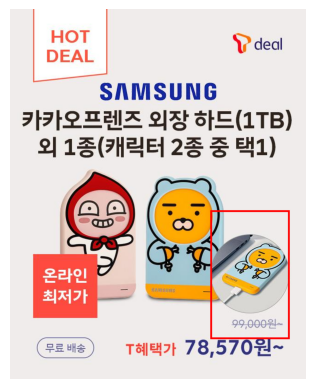

In [ ]:
# bbox 좌표 테스트

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 이미지 경로
image_path = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image/tdeal569.jpg'


# 주어진 좌표
center_x =
center_y =
width =
height =

# bounding box 좌표 계산
x1 = center_x - width / 2
y1 = center_y - height / 2
x2 = center_x + width / 2
y2 = center_y + height / 2

# 이미지 열기
image = Image.open(image_path)

# 이미지를 그리기 위한 객체 생성
draw = ImageDraw.Draw(image)

# bounding box 그리기 (red 색상, 두께 2)
draw.rectangle([x1, y1, x2, y2], outline="red", width=4)

# 이미지 시각화
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

In [ ]:
import json
import os

# 원본 JSON 파일 경로
input_json_file = '/content/poc_annotation.json'

# 이미지가 저장된 디렉토리 경로
image_directory = '/content/drive/MyDrive/PM1팀/이호은/24-ds-127_SKT_AI_Media/Dataset/00_POC_dataset/03_layout_dataset/raw_image'

# 출력할 부분을 저장할 JSON 파일 경로
output_json_file = '/content/filtered_94.json'

# 대상 파일 이름 (확장자까지 포함)
target_file_name = 'filtered (94).jpg'

# JSON에서 해당 파일 부분만 추출하는 함수
def extract_target_file(input_json_file, target_file_name, output_json_file):
    target_data = []

    # 파일을 한 줄씩 읽어서 처리
    with open(input_json_file, 'r', encoding='utf-8') as infile:
        for line in infile:
            try:
                data = json.loads(line.strip())
                json_file_name = data.get('source', {}).get('fileName', '')

                # 파일명과 확장자를 모두 비교
                if json_file_name == target_file_name:
                    target_data.append(data)
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {line}")
                print(f"Error message: {e}")

    if target_data:
        # 새로운 파일에 해당 부분 저장
        with open(output_json_file, 'w', encoding='utf-8') as outfile:
            json.dump(target_data, outfile, ensure_ascii=False, indent=4)
        print(f"'{target_file_name}'에 해당하는 부분이 '{output_json_file}'에 저장되었습니다.")
    else:
        print(f"'{target_file_name}'에 해당하는 데이터가 없습니다.")

# 실행
extract_target_file(input_json_file, target_file_name, output_json_file)

'filtered (94).jpg'에 해당하는 데이터가 없습니다.
